# Lab 2: Quantum teleportation

Welcome to this lab on quantum teleportation in which you'll solve a problem that Alice and Bob have been having. Relax, it's not a relationship problem! Alice possesses a qubit in an unknown state $\lvert \psi \rangle$ and she wishes to transfer this quantum state to Bob. However, they are very far apart and lack any means to transfer quantum information directly, only classical information. Is it possible to achieve their goal?

It turns out that if Alice and Bob share an entangled qubit pair, she can transfer her qubit state to Bob by sending two bits of classical information. This process is known as teleportation because, at the end, Bob will possess |ψ⟩, and Alice will no longer have it.

## Background

Quantum teleportation is a protocol that allows the transfer of quantum information from one qubit to another using entanglement and classical communication. It was proposed by Charles Bennett, Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres, and William Wootters in 1993. The process does not transmit the qubit itself but rather transfers the quantum state from the source qubit to the target qubit.

The protocol requires three qubits:

1. The qubit to be teleported (Alice's qubit)
2. One half of an entangled pair of qubits (Alice's second qubit)
3. The other half of the entangled pair (Bob's qubit)

The protocol can be summarized in the following steps:

1. Create an entangled pair of qubits (Bell pair) shared between Alice and Bob.
2. Alice performs a Bell basis measurement on her two qubits.
3. Alice sends the classical results of her measurement to Bob.
4. Bob applies appropriate quantum gates based on Alice's measurement results to obtain the teleported state.

## Implementation

In order to transfer a quantum bit, Alice and Bob require the help of a third party who provides them with a pair of entangled qubits. Next, Alice carries out certain operations on her qubit and shares the results with Bob through a classical communication channel. Finally, Bob performs a series of operations on his end to successfully obtain Alice's qubit. Now, let's delve deeper into each of these steps.

Our quantum circuit will consist of 3 qubits and 3 classical bits. The qubits will be named as follows:
- $s$: The "source" qubit containing the state $\lvert \psi \rangle$ which Alice wishes to transmit to Bob.
- $a$: The qubit which will initially store Alice's half of the entangled Bell pair.
- $b$: The qubit which will initially store Bob's half of the entangled Bell pair.

The teleportation protocol itself requires 2 classical bits, and we include a third one to use for measuring Bob's final state. The classical bits will be named as follows:
- $c0$: The classical bit that Alice uses to measure $a$.
- $c1$: The classical bit that Alice uses to measure $s$.
- $c2$: The classical bit that Bob uses to measure $b$.

### Exercise 1

Utilize two qubits to generate an entangled Bell pair state $\frac{\lvert 00 \rangle + \lvert 11 \rangle}{\sqrt{2}}$. Qubit 𝑎 is allocated to Alice, while qubit 𝑏 is designated for Bob.

*Hint*: This state can be generated using a Hadamard gate and a CNOT gate.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Qubit, Clbit
from qiskit_aer import AerSimulator



def create_bell_pair(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    """Creates a bell pair between qubits a and b."""
    qc = QuantumCircuit(qr, cr)
    # unpack qubits
    # the first qubit is s but we won't be using it in this exercise
    _, a, b = qr

    qc.h(a)
    qc.cx(a,b)

    return qc

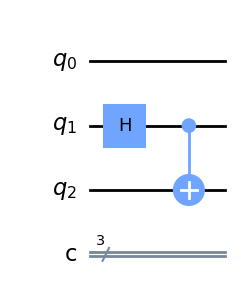

In [2]:
qr = QuantumRegister(3, name="q")
cr = ClassicalRegister(3, name="c")
qc = create_bell_pair(qr, cr)

qc.draw("mpl")

In [3]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex2a

grade_ex2a(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Let's assume Alice has qubit $a$ and Bob has qubit $b$ once they separate. Perhaps they really are having a relationship issue 😉.

### Exercise 2

Perform the next steps of the protocol:
1. Alice applies a CNOT gate with $s$ (the qubit containing $\lvert \psi \rangle$) as the control and $a$ as the target.
2. Alice applies a Hadamard gate to $s$.

In [4]:
def alice_gates(qr: QuantumRegister, cr: ClassicalRegister):
    """Creates Alices's gates"""
    qc = create_bell_pair(qr, cr)
    qc.barrier()  # Use barrier to separate steps
    s, a, b = qr

    qc.cx(s,a)
    qc.h(s)

    return qc

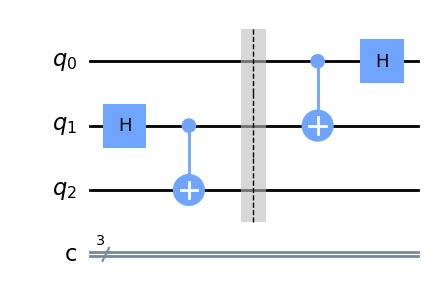

In [5]:
qc = alice_gates(qr, cr)
qc.draw("mpl")

In [6]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex2b

grade_ex2b(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 3

In this step, Alice performs a measurement on both qubits in her possession and saves the results in two classical bits. Afterward, she sends these two bits to Bob.

Complete the following code cell so that Alice measures qubit $a$ into classical bit $c0$ and qubit $s$ into classical bit $c1$.

In [7]:
def measure_and_send(qr: QuantumRegister, cr: ClassicalRegister):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc = alice_gates(qr, cr)
    qc.barrier()  # Use barrier to separate steps
    s, a, b = qr
    c0, c1, c2 = cr

    qc.measure(a,c0)
    qc.measure(s,c1)
    
    return qc

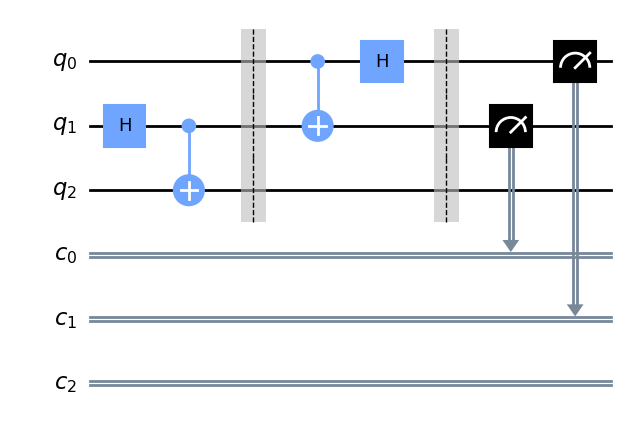

In [8]:
qc = measure_and_send(qr, cr)
qc.draw("mpl", cregbundle=False)

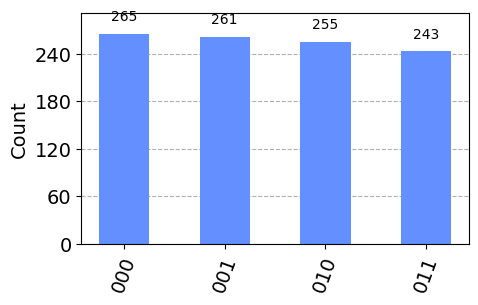

In [9]:
from qiskit.visualization import plot_histogram

backend_sim = AerSimulator()

job_1 = backend_sim.run(qc)
result_1 = job_1.result()
counts_1 = result_1.get_counts()

display(plot_histogram(counts_1, figsize = (5,3)))

In [10]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex2c

grade_ex2c(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 4

In this step, Bob, who is already in possession of qubit $b$, dynamically adds specific gates to the circuit based on the state of the classical bits received from Alice:

- If the bits are `00`, no action is required.
- If they are `01`, an 𝑋 gate (also known as a Pauli-X or a bit-flip gate) should be applied.
- For bits `10`, a 𝑍 gate (also known as a Pauli-Z or a phase-flip gate) should be applied. 
- Lastly, if the classical bits are `11`, a combined 𝑍𝑋 gate should be applied, which involves applying both the 𝑍 and 𝑋 gates in sequence.

In [11]:
def bob_gates(qr: QuantumRegister, cr: ClassicalRegister):
    """Uses qc.if_test to control which gates are dynamically added"""
    qc = measure_and_send(qr, cr)
    qc.barrier()  # Use barrier to separate steps
    s, a, b = qr
    c0, c1, c2 = cr
    
    with qc.if_test((c0,1)):
        qc.x(b)
    with qc.if_test((c1,1)):
        qc.z(b)
        
    return qc

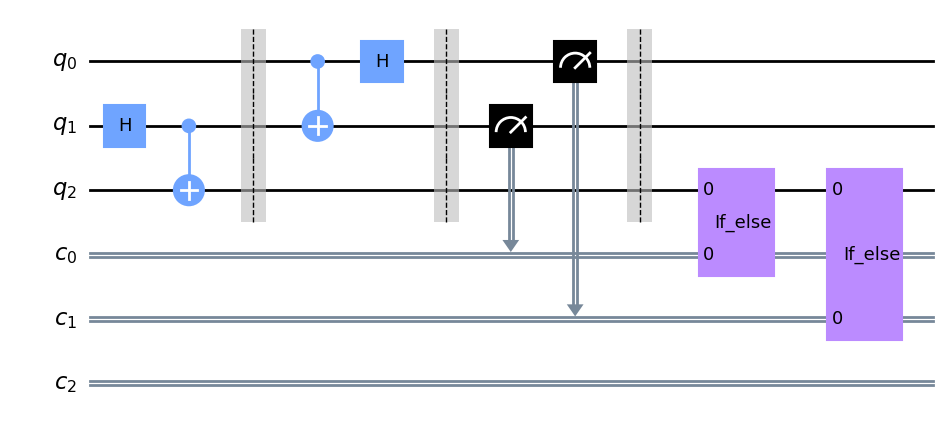

In [12]:
qc = bob_gates(qr, cr)
qc.draw("mpl", cregbundle=False)

In [13]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex2d

grade_ex2d(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


We will now have Bob measure his qubit into classical bit $c2$. After repeating the entire experiment multiple times, we can gather statistics on the measurement results to confirm that the teleportation worked correctly.

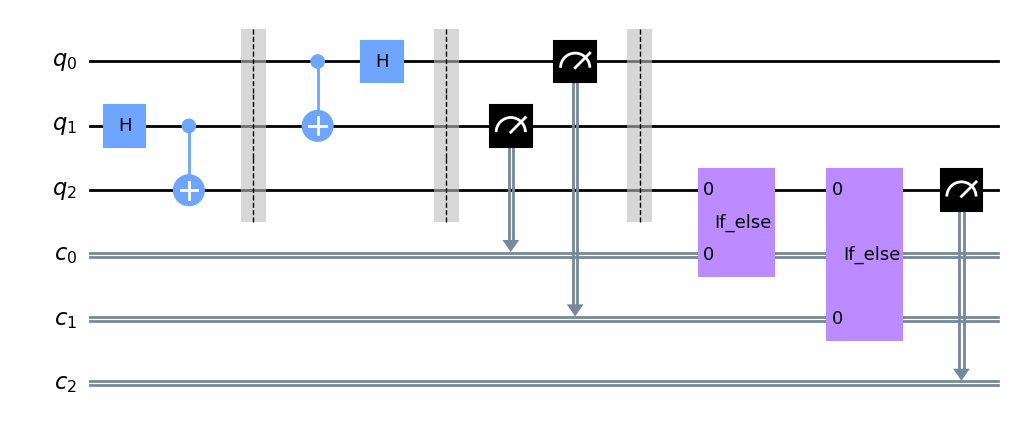

In [14]:
teleportation_circuit = bob_gates(qr, cr)
s, a, b = qr
c0, c1, c2 = cr
teleportation_circuit.measure(b, c2)
teleportation_circuit.draw("mpl")

Now that we have a teleportation circuit, let's ~~beam Captain Kirk to the surface of a strange planet~~ create and teleport a quantum state, and then run the circuit on a simulator.

### Exercise 5

In the following code cell, construct a full quantum teleportation circuit into the `teleport_superposition_circuit` variable, using the following steps:

- Construct a state preparation circuit. Prepare the qubit $s$ by applying an $R_x$ rotation with angle $\pi / 4$.
- Combine the state preparation circuit with your previously built teleportation circuit.

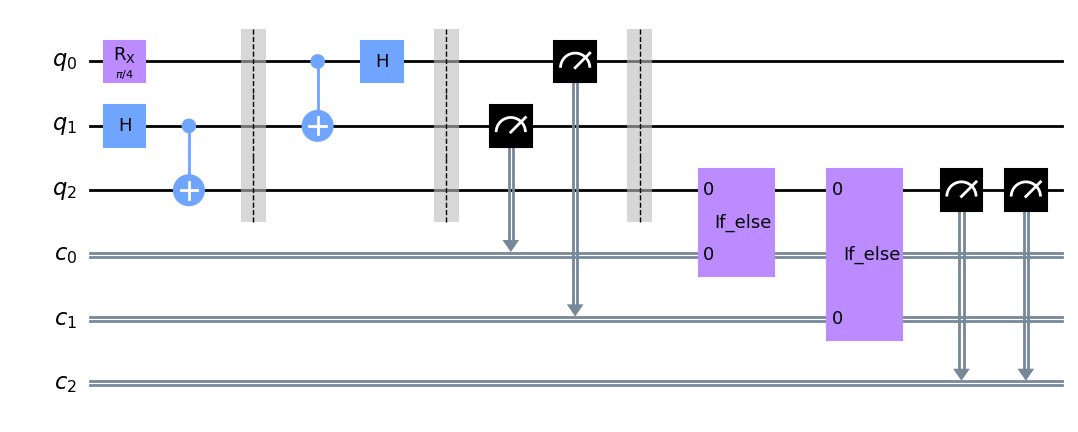

In [17]:
import math

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Qubit, Clbit
from qiskit_aer import AerSimulator

qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')

s, a, b = qr
c0, c1, c2 = cr

teleport_superposition_circuit = QuantumCircuit(qr,cr)
teleport_superposition_circuit.rx(math.pi/4, s)

teleport_superposition_circuit.compose(teleportation_circuit, inplace=True)


teleport_superposition_circuit.measure(b, c2)


# Uncomment this line to draw your circuit
teleport_superposition_circuit.draw("mpl", cregbundle=False)

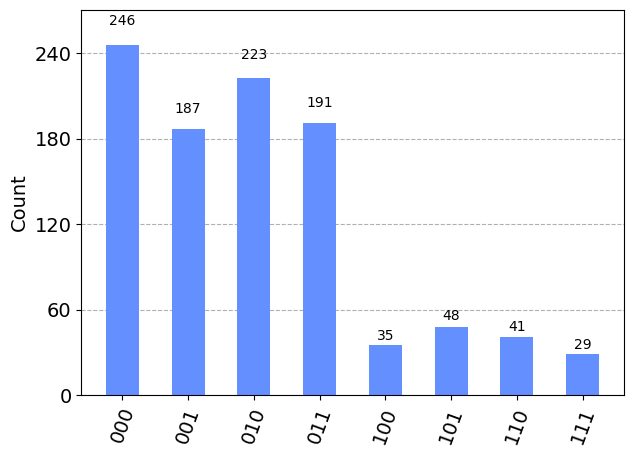

In [18]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

sim = AerSimulator()
transpiled_circuit = transpile(teleport_superposition_circuit, sim)

# run job
shots = 1000
job = sim.run(transpiled_circuit, shots=shots, dynamic=True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
plot_histogram(exp_counts)

Let's compute the distribution of just Bob's measurement by marginalizing over the other measured bits.

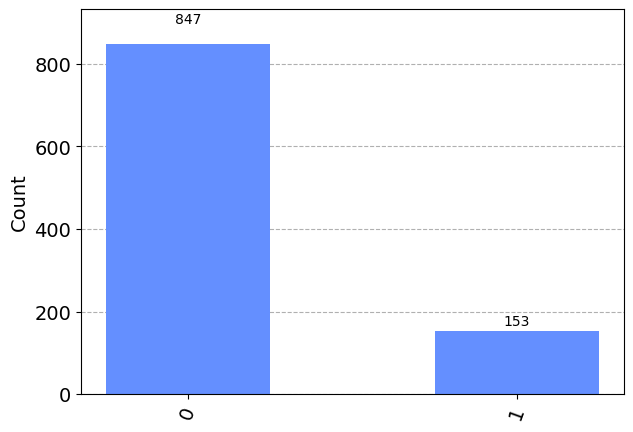

In [19]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts

bobs_counts = marginal_counts(exp_counts, [qr.index(b)])
plot_histogram(bobs_counts)

The marginal distribution should be somewhat close to the ideal probabilities.

In [20]:
from qc_grader.challenges.spring_2023 import grade_ex2e

grade_ex2e(bobs_counts)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Now that we're fairly certain that ~~Captain Kirk~~ Alice's qubit will teleport safely, let's execute the quantum teleportation circuit on real hardware.

In [21]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

In [ ]:
hub = "YOUR_HUB"
group = "YOUR_GROUP"
project = "YOUR_PROJECT"

backend_name = "ibm_peekskill"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

In [ ]:
# backend.target.add_instruction(IfElseOp, name="if_else") # Uncomment if necessary
qc_transpiled = transpile(teleport_superposition_circuit, backend)

In [ ]:
job = backend.run(qc_transpiled, shots=1000, dynamic=True)

Because it takes time to run on the real backend, you typically use job_id to call in jobs after a time.
The following code invokes jobs through job_id and checks the execution status. Here's how to use it.

In [ ]:
retrieve_job = provider.retrieve_job(job.job_id())
retrieve_job.status()

If your job succesfully finished, let's import results.

In [ ]:
# Get the results and display them
exp_result = retrieve_job.result()
exp_counts = exp_result.get_counts()
plot_histogram(exp_counts)

In [ ]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts

bobs_qubit = 2
bobs_counts = marginal_counts(exp_counts, [bobs_qubit])
plot_histogram(bobs_counts)